## Week 10_Wed - LINEAR DATA FITTING WITH UNCERTANTIES

In [1]:
#standard importing
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [4]:
#Read in the data to a numpy array
data = np.genfromtxt("HW10_2data.dat", names=True, dtype=None)

# print out all columns we just got for free
data.dtype

dtype([('X', '<f8'), ('Y', '<f8'), ('Y_ERR', '<f8'), ('Z', '<f8'), ('Z_ERR', '<f8')])

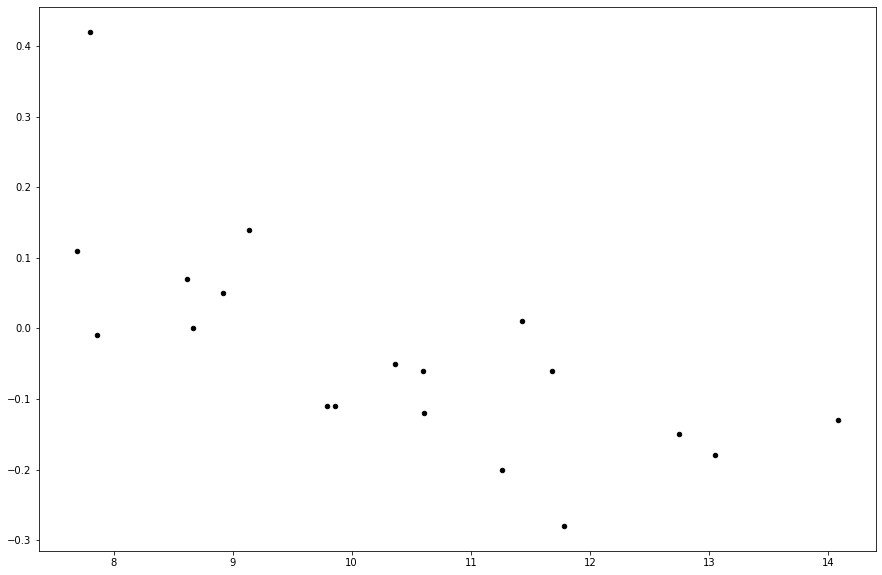

In [5]:
#First let's see what this data looks like
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')

# Cool! The data actually looks pretty linear so we can assume the function we are fitting *is* linear

In [6]:
# let's make a linear function the normal way
def linear(x, m, b):
    return m * x + b

raw:  -0.05818663749944188 0.5653511377902967
raw:  [ 0.00020654 -0.00213008] [-0.00213008  0.02264763]


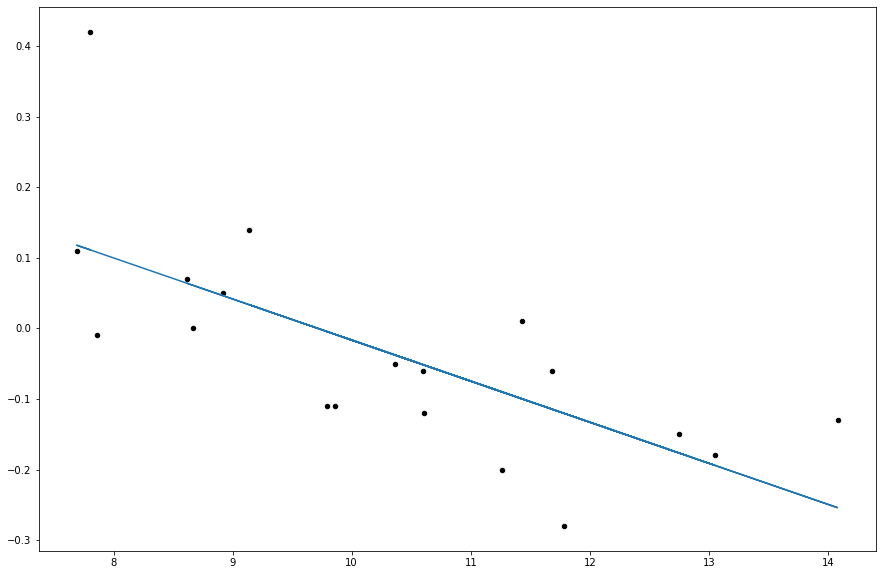

In [7]:
# let's do a linear fit to the data

popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


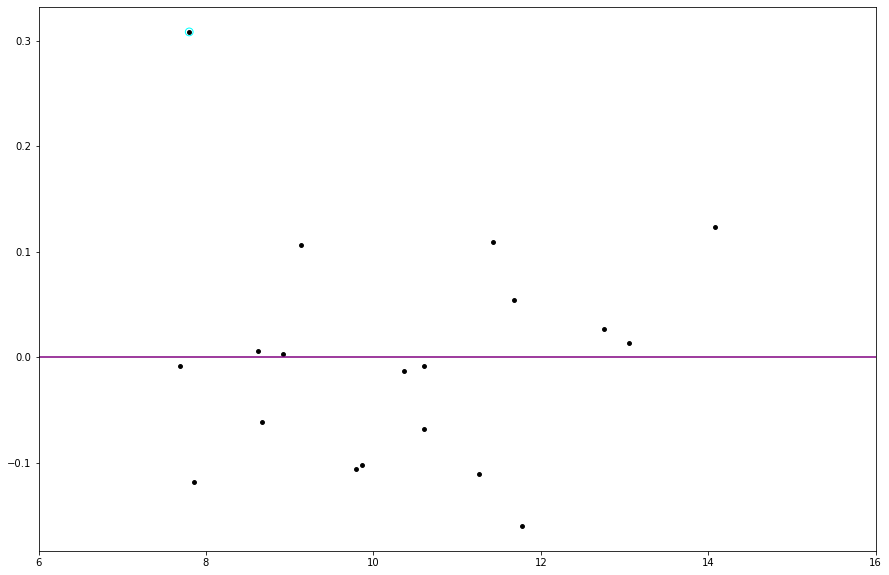

In [8]:
#Let's look into wich data are way off the fit.

residual = data['Y']-linear(data['X'],*popt)
x = np.linspace(5,20,1000)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(6,16)

outlier = np.absolute(residual)>0.2
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')


raw:  -0.05818663749944188 0.5653511377902967
outliers accounted for:  -0.04338146805673531 0.3967292540601484


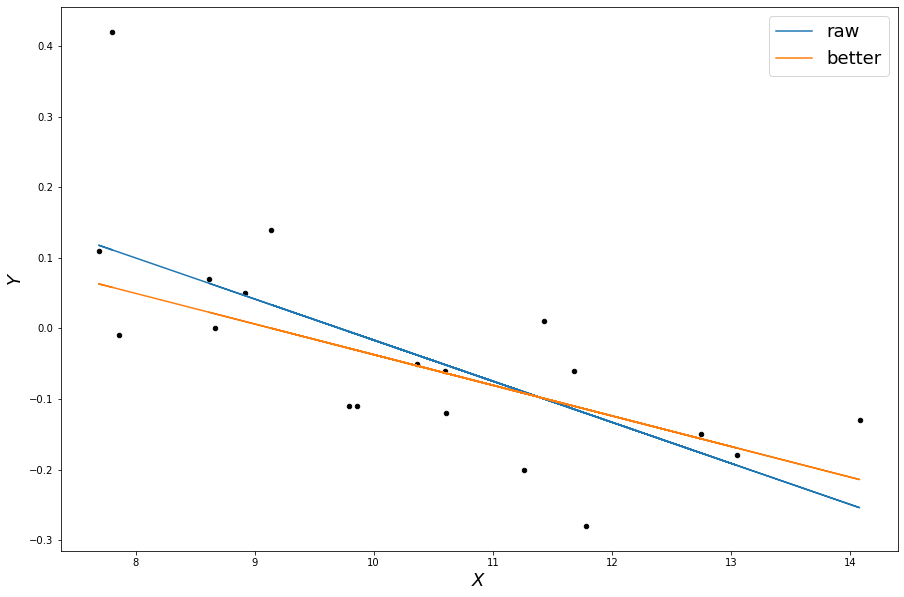

In [10]:
# our values for the raw data above:
# slope:    -0.058187
# intercept: 0.565351
popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Y'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
# cleaner error bars than last time, play around with the parameters
#ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
#            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

-0.038335615619586275 0.3463734445963487


NameError: name 'popt_clean' is not defined

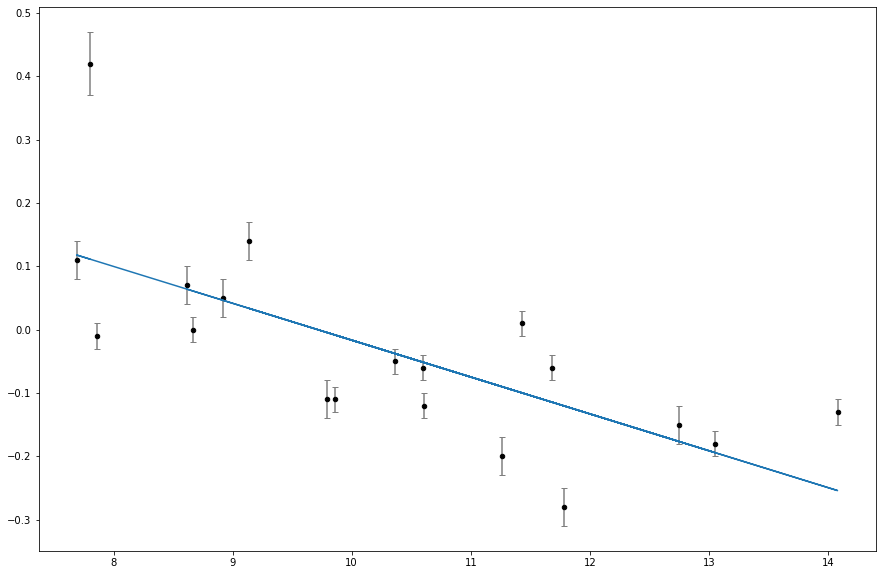

In [9]:
# lets account for the errors
# by pasing sigma, scipy knows to weight data according to their errors 
# naturally, sigma is expected to be the same size and correspond to y
# notice: this only accounts for y error
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: -0.0585, mean intercept: 0.5692


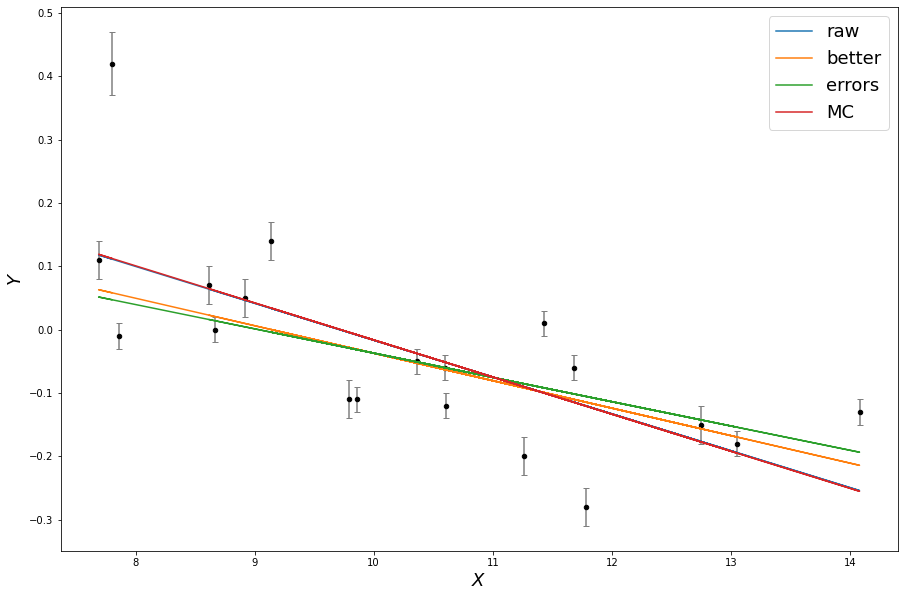

In [11]:
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [13]:
# oh right, that outlier.

mask = data['Y'] < 0.3

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, ydat, ydat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

data size:  18
slope: -0.0433 $\pm$ 0.0033, mean intercept: 0.3928


slope: -0.0435 $\pm$ 0.0033, mean intercept: 0.3946
slope: -0.0436 $\pm$ 0.0031, mean intercept: 0.3957
slope: -0.0436 $\pm$ 0.0036, mean intercept: 0.3958
slope: -0.0435 $\pm$ 0.0033, mean intercept: 0.3950
slope: -0.0435 $\pm$ 0.0034, mean intercept: 0.3946
slope: -0.0436 $\pm$ 0.0036, mean intercept: 0.3957
slope: -0.0434 $\pm$ 0.0031, mean intercept: 0.3933
slope: -0.0435 $\pm$ 0.0032, mean intercept: 0.3941
slope: -0.0436 $\pm$ 0.0033, mean intercept: 0.3953
slope: -0.0437 $\pm$ 0.0035, mean intercept: 0.3969
slope: -0.0436 $\pm$ 0.0032, mean intercept: 0.3956
slope: -0.0434 $\pm$ 0.0033, mean intercept: 0.3938
slope: -0.0436 $\pm$ 0.0033, mean intercept: 0.3962
slope: -0.0438 $\pm$ 0.0031, mean intercept: 0.3977
slope: -0.0436 $\pm$ 0.0034, mean intercept: 0.3952
slope: -0.0436 $\pm$ 0.0033, mean intercept: 0.3959
slope: -0.0433 $\pm$ 0.0034, mean intercept: 0.3926
slope: -0.0434 $\pm$ 0.0032, mean intercept: 0.

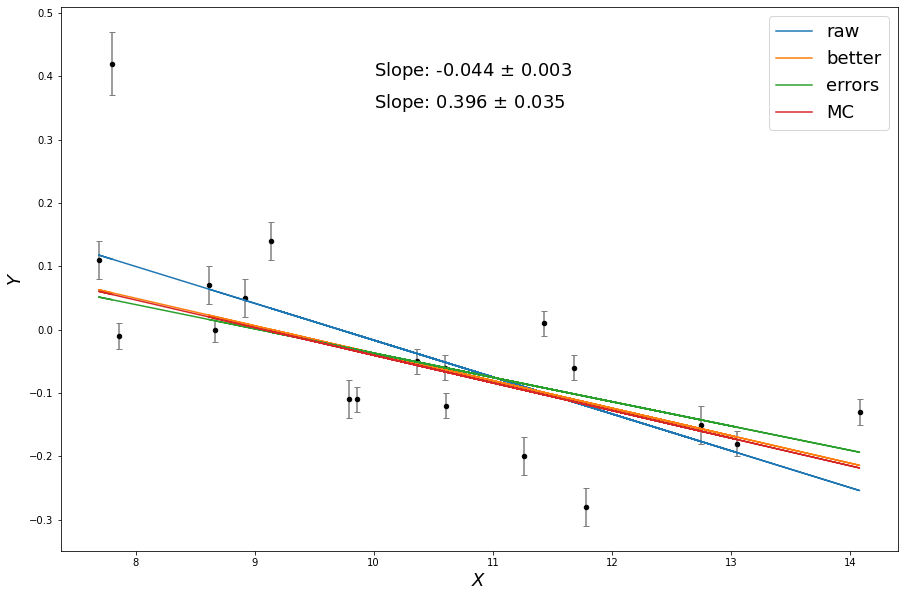

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, ydat, ydat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

0.39594348596965323


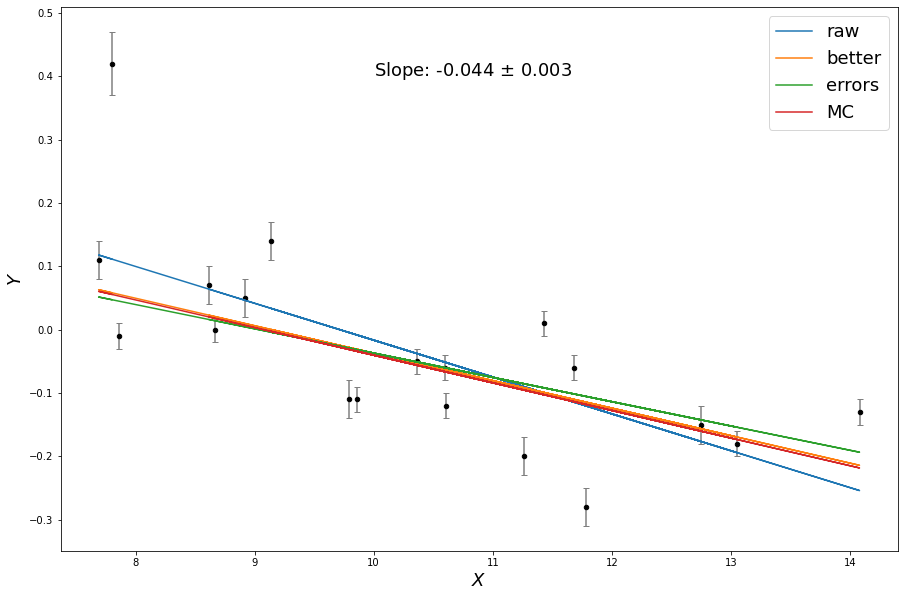

In [15]:
# here's an example of the use of lampda functions: simplifying or modifying another function
params, other = opt.curve_fit(lambda x, b: linear(x, np.mean(slope), b), xdat, ydat)

fixed_int = params[0]

print(fixed_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), fixed_int), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
# ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

MC : mean slope: -0.0518, mean y uncertainty: 0.0258, mean x uncertainty: 0.5000


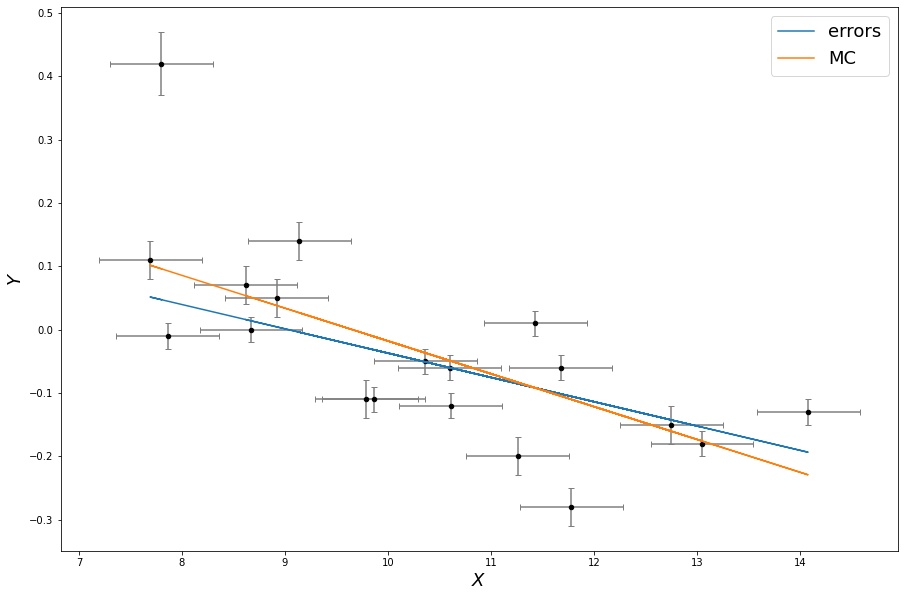

In [54]:
# exercise: we can't know the x data perfectly
# suppose the data have uniform x errors of 0.5

def mcFit(x, y, x_err1, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x + x_err1*weights

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], .5, data['Y_ERR'])



fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],xerr=data['X']*0 +.5, yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
#ax.plot(data['X'], linear(data['X'], *popt), label='raw')
#ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

print('MC : mean slope: {:6.4f}, mean y uncertainty: {:6.4f}, mean x uncertainty: {:6.4f}'.format(np.mean(slope), np.mean(data['Y_ERR']), .5))

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()



# use the MC technique to estimate the slope *AND* the uncertainty taking into account these errors

MC : mean slope: -0.0556, mean y uncertainty: 0.0258, mean x uncertainty: 0.2382


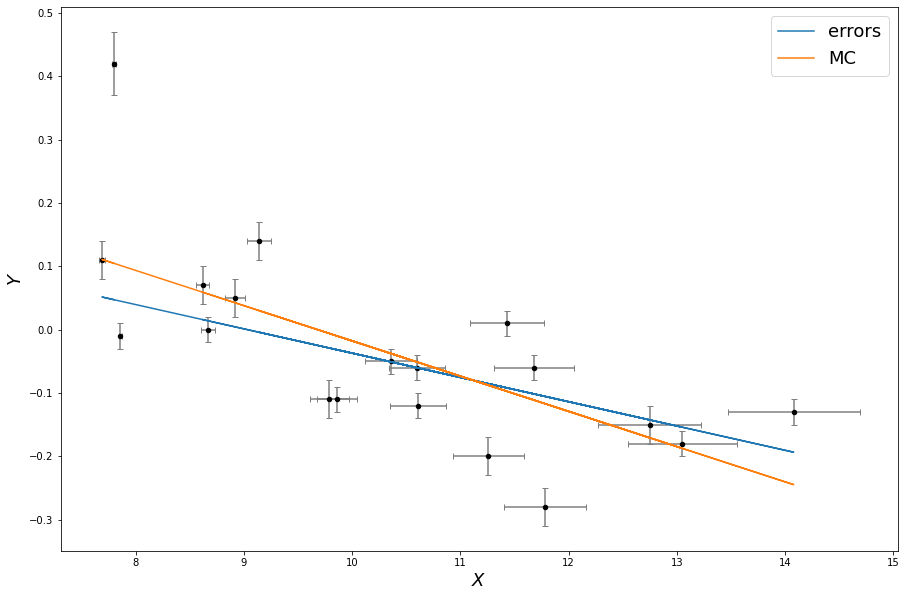

In [58]:
# repeat this exercise, but supposing the errors INCREASE as we move away from X = 8 (as they do)
# to be precise: suppose X_ERR = |x - 8| /10, e.g. it increases by .1 per unit 

def mcFit(x, y, x_err1, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x + x_err1*weights

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], abs(data['X'] - 8)/10, data['Y_ERR'])

print('MC : mean slope: {:6.4f}, mean y uncertainty: {:6.4f}, mean x uncertainty: {:6.4f}'.format(np.mean(slope), np.mean(data['Y_ERR']), np.mean(abs(data['X'] - 8)/10)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],xerr=abs(data['X'] - 8)/10, yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
#ax.plot(data['X'], linear(data['X'], *popt), label='raw')
#ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()